In this Homework, you will make a question answering bot using using LSTM.

TODO:
1. Tokenize the data and create a vocabulary using [sentencepiece](https://github.com/google/sentencepiece/blob/master/python/README.md). Set `vocab_size=1000, pad_id=0, unk_id=1, bos_id=2, eos_id=3`. After making the tokenization model encode your data and don't forget to add <sos\> and <eos\>.
2. Pad your source and target data.
3. Split the data into 80:20 train and test set.
4. Create and train your a simple LSTM based QA model. You can follow the architecture design given below.
5. Create and train an attention based LSTM QA model. Follow the design covered in the lecture. See fig. 2 below.
6. Evaluate your models on test data and calculate the [bleu score](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/).


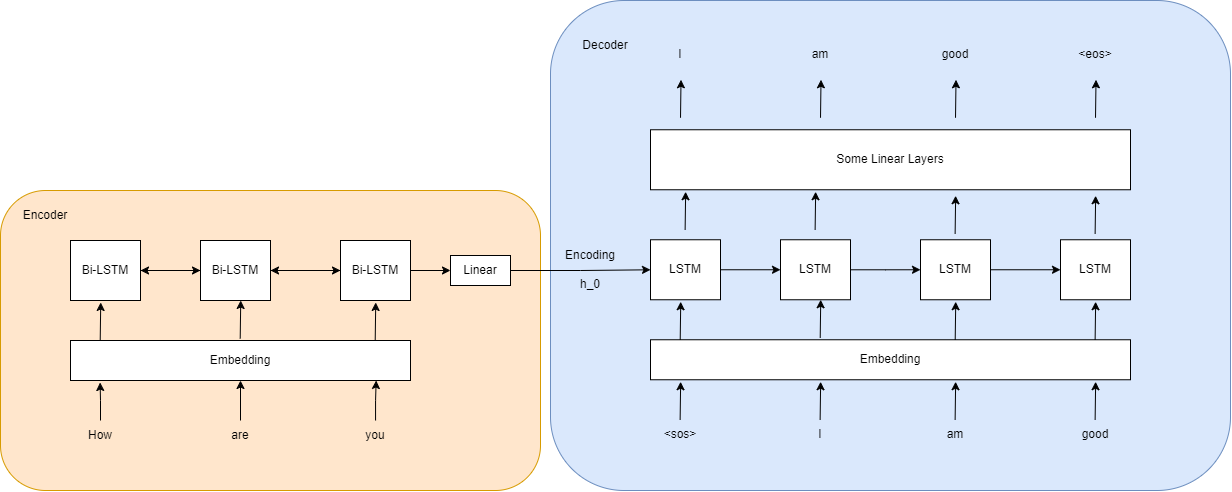

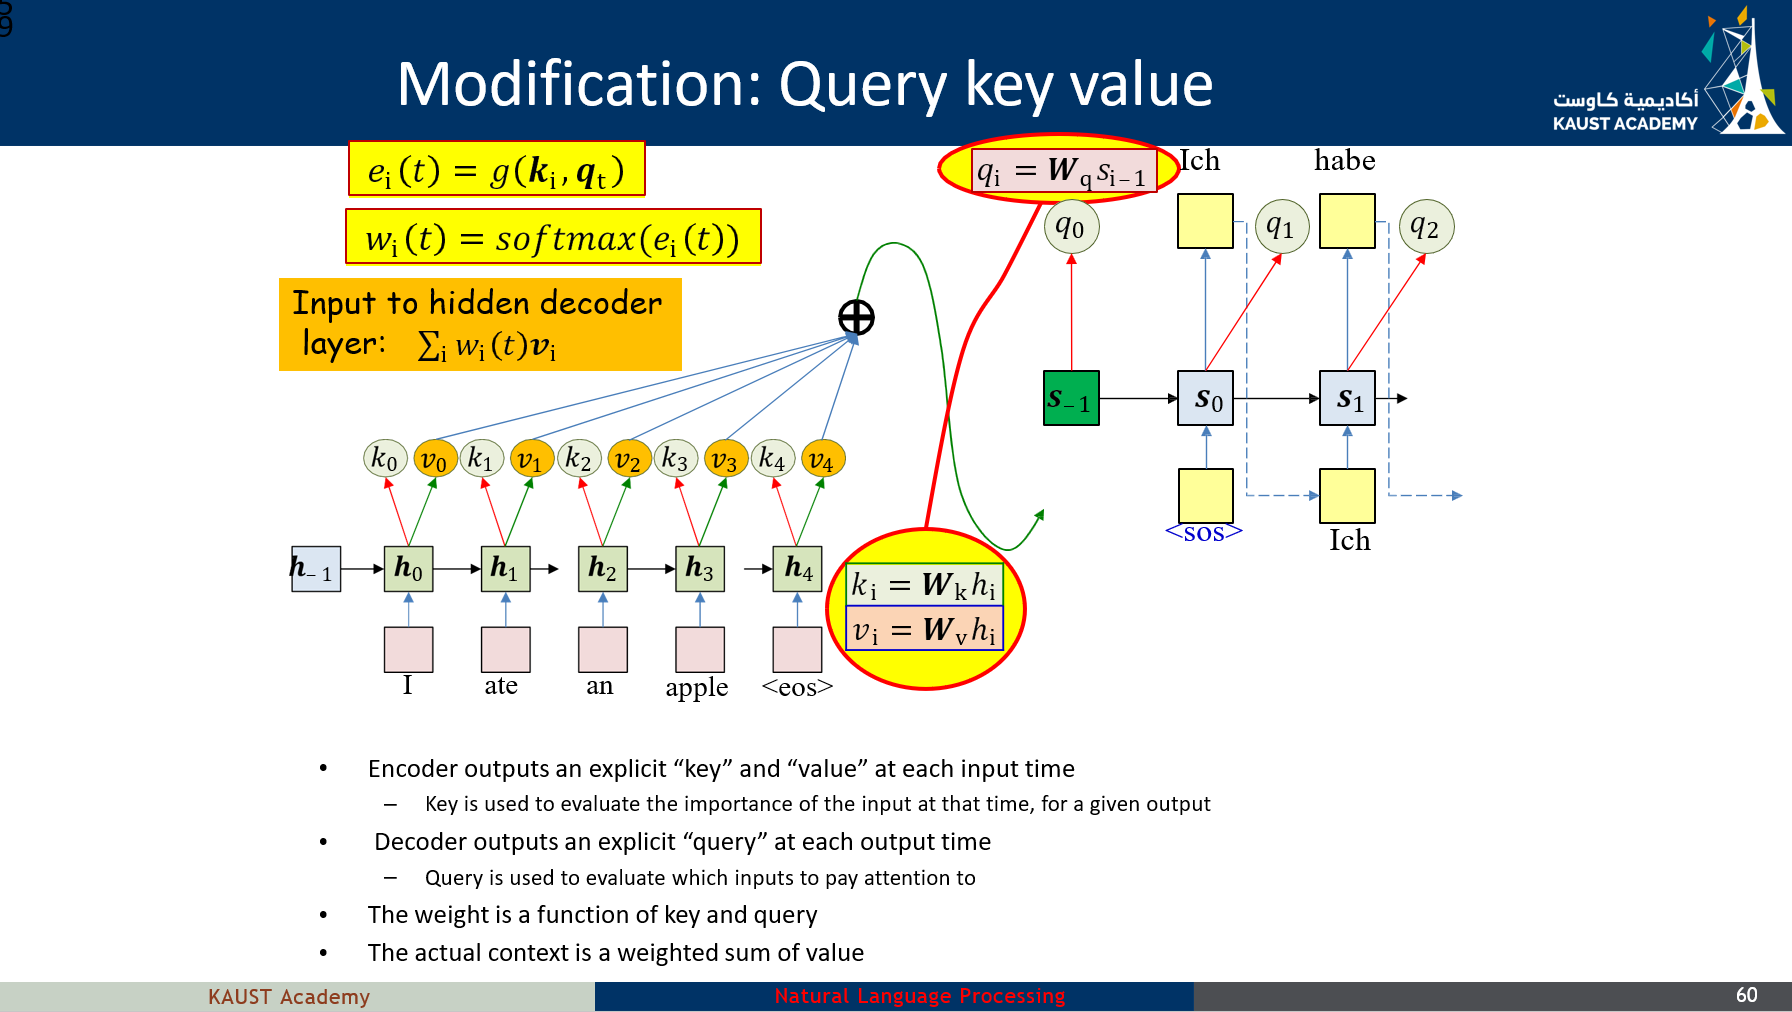

Hints:

1. Use Bi-directional LSTM in encoder.
2. Learning rate matters a lot and will need to be managed during training. Either use a learning rate schedular or optimizers with adaptive learning rate (e.g. adagrad).
3. The training and generation process will slightly differ. You need to do training using teacher forcing method.
4. Your source sentences will contain pad tokens and they will affect the encoding generated by the encoder. This is not ideal. To deal with this try using `torch.nn.utils.rnn.pack_padded_sequence` and `torch.nn.utils.rnn.pad_packed_sequence`. Study how it works and how you can use it.
5. For attention based model, you will need to write the decoder loop yourself. So, you will need to use `torch.nn.LSTMCell`.

In [1]:
!wget https://qnamakerstore.blob.core.windows.net/qnamakerdata/editorial/english/qna_chitchat_professional.tsv

--2024-07-29 14:09:04--  https://qnamakerstore.blob.core.windows.net/qnamakerdata/editorial/english/qna_chitchat_professional.tsv
Resolving qnamakerstore.blob.core.windows.net (qnamakerstore.blob.core.windows.net)... 20.60.81.165
Connecting to qnamakerstore.blob.core.windows.net (qnamakerstore.blob.core.windows.net)|20.60.81.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 981694 (959K) [text/plain]
Saving to: 'qna_chitchat_professional.tsv'

qna_chitchat_profes 100%[===================>] 958.69K  1.49MB/s    in 0.6s    

2024-07-29 14:09:05 (1.49 MB/s) - 'qna_chitchat_professional.tsv' saved [981694/981694]



In [2]:
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils

In [3]:
import pandas as pd
pd.read_csv("qna_chitchat_professional.tsv", sep="\t")[["Question", "Answer"]].to_csv("qna_chitchat_professional.tsv", index=False, sep="\t")

In [4]:
df = pd.read_csv("qna_chitchat_professional.tsv", sep="\t")[["Question", "Answer"]]

In [5]:
df

,Question,Answer
0,Do you get hurt?,I don't have a body.
1,Do you have fingers?,I don't have a body.
2,Do you ever breathe,I don't have a body.
3,Do you masticate?,I don't have a body.
4,Can you throw up?,I don't have a body.
...,...,...
9788,I'm tired from work,I hope you're able to get some rest soon.
9789,I'm totally drained,I hope you're able to get some rest soon.
9790,I'm totally exhausted,I hope you're able to get some rest soon.
9791,Zzzzz,I hope you're able to get some rest soon.


## Tokenize

In [6]:
# %pip install sentencepiece

In [7]:
import sentencepiece as spm

In [8]:
text_data = np.array(df)

with open('text_data.txt', 'w', encoding='utf-8') as f:
    for lines in text_data:
        for line in lines:
            f.write(f"{line}\n")

In [9]:
spm.SentencePieceTrainer.train(input='text_data.txt', model_prefix='m', vocab_size=1000, pad_id=0, unk_id=1, bos_id=2, eos_id=3)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: text_data.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 1000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential

In [10]:
sp = spm.SentencePieceProcessor(model_file='m.model')

In [11]:
sos_id = sp.piece_to_id('<s>')
eos_id = sp.piece_to_id('</s>')

tokenized_data = []
for texts in text_data:
    tokenized_data.append([[sos_id] + sp.encode(texts[0]) + [eos_id], [sos_id] + sp.encode(texts[1]) + [eos_id]])

print(f"Original: {text_data[0]}")
print(f"Tokenized: {tokenized_data[0]}")

Original: ['Do you get hurt?' "I don't have a body."]
Tokenized: [[2, 39, 7, 61, 516, 12, 3], [2, 5, 18, 6, 10, 17, 14, 289, 4, 3]]


## Padding

In [12]:
max_len = max([len(text) for data in tokenized_data for text in data])
max_len

46

In [13]:
def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded

In [14]:
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

In [15]:
tokenized_data = [[pad_sequences(data[0], max_len), pad_sequences(data[1], max_len)] for data in tokenized_data]
tokenized_data[0]

[array([  2,  39,   7,  61, 516,  12,   3,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]),
 array([  2,   5,  18,   6,  10,  17,  14, 289,   4,   3,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0])]

## Data Splitting

In [16]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(tokenized_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
train_data[0]

[array([  2,  39,   7, 316,  71,  76, 309,  55,  12,   3,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]),
 array([  2,   5,  18,   6,  10,  17,  14, 289,   4,   3,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0])]

In [17]:
from torch.utils.data import DataLoader, Dataset

class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]

In [18]:
train_set = MyDataset(train_data)
val_set = MyDataset(val_data)
test_set = MyDataset(test_data)

In [19]:
BATCH_SIZE = 32

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, shuffle=False)

## LSTM Model

In [20]:
class LSTM_Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional=True):
        super(LSTM_Encoder, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * self.num_directions, output_dim)
    
    def initialize_hidden_state(self, batch_size):
        return (torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_dim),
                torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_dim))
    
    def forward(self, x):
        # x = (batch_size, sequence_length)
        embedded = self.embedding(x)  # (batch_size, sequence_length, embedding_dim)
        
        lengths = (x != 0).sum(dim=1).cpu()
        packed_embedded = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        
        hidden = self.initialize_hidden_state(x.shape[0])
        hidden = (hidden[0].to(x.device), hidden[1].to(x.device))
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded, hidden)
        
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        last_output = output[torch.arange(output.size(0)), lengths - 1]
        
        if self.bidirectional:
            last_output = torch.cat((last_output[:, :self.hidden_dim], last_output[:, self.hidden_dim:]), dim=1)
        
        dropped = self.dropout(last_output)
        final_output = self.fc(dropped)
        
        return final_output, hidden

In [21]:
class LSTM_Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers):
        super(LSTM_Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim + hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, features):
        batch_size = x.shape[0]  # (batch_size, seq_length)
        seq_length = x.shape[1]
        
        x = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        
        # Concat x input and encoded features as a skip connection
        features_expanded = features.unsqueeze(1).expand(-1, seq_length, -1)  # (batch_size, seq_length, hidden_dim)
        x = torch.cat((x, features_expanded), dim=2)
        
        self.hidden = features.unsqueeze(0).expand(self.num_layers, batch_size, -1).contiguous()
        self.cell_state = features.unsqueeze(0).expand(self.num_layers, batch_size, -1).contiguous()
        
        x, (self.hidden, self.cell_state) = self.lstm(x, (self.hidden, self.cell_state))
        #  (batch_size, seq_length, hidden_dim)
        
        x = self.dropout(x)
        x = self.fc(x)  # (batch_size, seq_length, output_dim)
        
        return x, self.hidden

In [22]:
class LSTM_QA(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim_enc, num_layers_enc, output_dim_dec, num_layers_dec):
        super(LSTM_QA, self).__init__()
        self.encoder = LSTM_Encoder(vocab_size, embedding_dim, hidden_dim, output_dim_enc, num_layers_enc, bidirectional=True)
        self.decoder = LSTM_Decoder(vocab_size, embedding_dim, output_dim_enc, output_dim_dec, num_layers_dec)
        
    def forward(self, question, answer):
        encoded, _ = self.encoder(question)
        out, _ = self.decoder(answer, encoded)
        return out
    
    def answer(self, questions, max_length=50):
        batch_size = questions.shape[0]
        device = questions.device
        with torch.no_grad():
            features, _ = self.encoder(questions)

            start_token = torch.full((batch_size, 1), sp.piece_to_id('<s>'), dtype=torch.long, device=device)
            generated_answers = start_token

            for _ in range(max_length):
                outputs, _ = self.decoder(generated_answers, features)
                predicted = outputs.argmax(2)[:, -1:]
                generated_answers = torch.cat([generated_answers, predicted], dim=1)
                
                if (predicted == sp.piece_to_id('</s>')).all():
                    break

            generated_answers = generated_answers[:, 1:] 
            end_positions = (generated_answers == sp.piece_to_id('</s>')).float().argmax(1)
            
            decoded_answers = []
            for i, end_pos in enumerate(end_positions):
                if end_pos == 0:
                    answer = generated_answers[i].tolist()
                else:
                    answer = generated_answers[i, :end_pos].tolist()
                decoded_answers.append(sp.decode_ids(answer))

        return decoded_answers

In [23]:
def train(model, criterion, optimizer, num_epochs=50):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_training_loss = 0
        
        for questions, answers in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]'):
            questions = questions.to(device)
            answers = answers.type(torch.long).to(device)
            
            question_lengths = (questions != 0).sum(dim=1).cpu()
            answer_lengths = (answers != 0).sum(dim=1).cpu()
            
            outputs = model(questions, answers[:, :-1])
            
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), answers[:, 1:].reshape(-1))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_training_loss += loss.item()
        
        avg_train_loss = running_training_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        running_val_loss = 0
        
        with torch.no_grad():
            for questions, answers in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]'):
                questions = questions.to(device)
                answers = answers.type(torch.long).to(device)
                
                question_lengths = (questions != 0).sum(dim=1).cpu()
                answer_lengths = (answers != 0).sum(dim=1).cpu()
                
                outputs = model(questions, answers[:, :-1])
                
                loss = criterion(outputs.reshape(-1, outputs.shape[2]), answers[:, 1:].reshape(-1))
                running_val_loss += loss.item()
        
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f'\nEpoch: {epoch+1}/{num_epochs}, Training loss: {avg_train_loss:.4f}, Validation loss: {avg_val_loss:.4f}')
    
    return train_losses, val_losses

In [24]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [25]:
lstm_model = LSTM_QA(sp.vocab_size(), 256, 512, 512, 2, sp.vocab_size(), 2).to(device)
lstm_model = nn.DataParallel(lstm_model, device_ids=[0, 1]).to(device)

In [26]:
criterion = nn.CrossEntropyLoss(ignore_index=sp.piece_to_id('<pad>')).to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

In [27]:
train_losses, val_losses = train(lstm_model, criterion, optimizer, num_epochs=15)

Epoch 1/15 [Val]: 100%|██████████| 49/49 [00:00<00:00, 61.62it/s]



Epoch: 1/15, Training loss: 3.2186, Validation loss: 1.8024


Epoch 2/15 [Val]: 100%|██████████| 49/49 [00:00<00:00, 61.42it/s]



Epoch: 2/15, Training loss: 1.1698, Validation loss: 0.6140


Epoch 3/15 [Val]: 100%|██████████| 49/49 [00:00<00:00, 61.30it/s]



Epoch: 3/15, Training loss: 0.5165, Validation loss: 0.3364


Epoch 4/15 [Val]: 100%|██████████| 49/49 [00:00<00:00, 58.73it/s]



Epoch: 4/15, Training loss: 0.3068, Validation loss: 0.2303


Epoch 5/15 [Val]: 100%|██████████| 49/49 [00:00<00:00, 60.85it/s]



Epoch: 5/15, Training loss: 0.1987, Validation loss: 0.1664


Epoch 6/15 [Val]: 100%|██████████| 49/49 [00:00<00:00, 60.30it/s]



Epoch: 6/15, Training loss: 0.1266, Validation loss: 0.1486


Epoch 7/15 [Val]: 100%|██████████| 49/49 [00:00<00:00, 60.70it/s]



Epoch: 7/15, Training loss: 0.0810, Validation loss: 0.1226


Epoch 8/15 [Val]: 100%|██████████| 49/49 [00:00<00:00, 60.55it/s]



Epoch: 8/15, Training loss: 0.0498, Validation loss: 0.1208


Epoch 9/15 [Val]: 100%|██████████| 49/49 [00:00<00:00, 59.80it/s]



Epoch: 9/15, Training loss: 0.0365, Validation loss: 0.1138


Epoch 10/15 [Val]: 100%|██████████| 49/49 [00:00<00:00, 60.56it/s]



Epoch: 10/15, Training loss: 0.0245, Validation loss: 0.1200


Epoch 11/15 [Val]: 100%|██████████| 49/49 [00:00<00:00, 60.50it/s]



Epoch: 11/15, Training loss: 0.0175, Validation loss: 0.1149


Epoch 12/15 [Val]: 100%|██████████| 49/49 [00:00<00:00, 60.94it/s]



Epoch: 12/15, Training loss: 0.0127, Validation loss: 0.1172


Epoch 13/15 [Val]: 100%|██████████| 49/49 [00:00<00:00, 60.64it/s]



Epoch: 13/15, Training loss: 0.0090, Validation loss: 0.1211


Epoch 14/15 [Val]: 100%|██████████| 49/49 [00:00<00:00, 61.13it/s]



Epoch: 14/15, Training loss: 0.0077, Validation loss: 0.1256


Epoch 15/15 [Val]: 100%|██████████| 49/49 [00:00<00:00, 60.68it/s]


Epoch: 15/15, Training loss: 0.0064, Validation loss: 0.1241


In [28]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.legend(['Train', 'Validation'])
    plt.show()

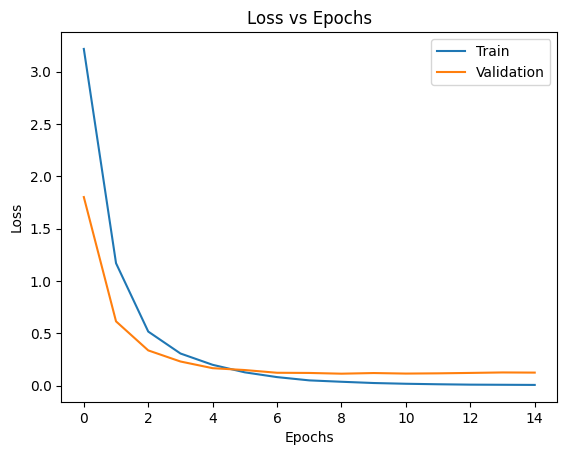

In [29]:
plot_losses(train_losses, val_losses)

In [30]:
from nltk.translate.bleu_score import corpus_bleu

test_loader = DataLoader(test_set, batch_size=128)

generated_captions = []
reference_captions = []

lstm_model.eval()
with torch.no_grad():
    for question, answer in tqdm(test_loader):
        question = question.to(device)

        generated_answers = lstm_model.module.answer(question, max_length=50)
        answer = sp.decode_ids(answer.cpu().tolist())
        
        generated_captions += generated_answers
        reference_captions += answer

bleu_score = corpus_bleu(reference_captions, generated_captions)
print("BLEU Score:", bleu_score)

100%|██████████| 16/16 [00:09<00:00,  1.69it/s]


BLEU Score: 0.8335764114972604


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [31]:
import random

for _ in range(3):
    question, answer = random.choice(test_set)
    lstm_model.eval()
    with torch.no_grad():
        question = torch.tensor(question).to(device).unsqueeze(0)
        question = question.to(device)

        generated_answer = lstm_model.module.answer(question, max_length=50)
        generate_answer = ' '.join(generated_answer)
        answer = ''.join(sp.decode_ids(answer.tolist()))
        question = ' '.join(sp.decode_ids(question.cpu().tolist()))
        
        print(f'Question: {question}\nReference Answer: {answer}\nGenerated Answer: {generated_answer}\n')

Question: No one wants to do things with me
Reference Answer: I'm here if you need me.
Generated Answer: ["I'm here if you need me."]

Question: I'm so happy I could just die
Reference Answer: I'm happy to hear that.
Generated Answer: ['The National Suicide Prevention Lifeline is available 24/7. You can call 1-800-273-8255 or visit www.suicidepreventionlifeline.org.']

Question: Why thank you
Reference Answer: You're welcome.
Generated Answer: ["You're welcome."]



## Attention

In [32]:
class MultiheadAttention(nn.Module):
    def __init__(self, embedding_size, hidden_size, num_heads, dropout=0.5):
        super(MultiheadAttention, self).__init__()
        
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        
        self.query = nn.Linear(embedding_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        
        self.output_proj = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        query = self.query(query)  # (batch_size, seq_len, hidden_size)
        key = self.key(key)        # (batch_size, seq_len, hidden_size)
        value = self.value(value)  # (batch_size, seq_len, hidden_size)
        
        query = query.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        key = key.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        value = value.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        
        scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        context = torch.matmul(attention_weights, value)
        
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.hidden_size)
        output = self.output_proj(context)
        
        return output

In [33]:
class Attention_Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, num_heads):
        super(Attention_Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.multihead_attention = MultiheadAttention(embedding_dim, hidden_dim, num_heads)
        self.lstm_cells = nn.ModuleList([nn.LSTMCell(embedding_dim + 2*hidden_dim if i == 0 else hidden_dim, hidden_dim) for i in range(num_layers)])
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, features):
        batch_size = x.shape[0]
        seq_length = x.shape[1]

        x = self.embedding(x)  # (batch_size, seq_length, embedding_dim)

        self.hidden = [features for _ in range(self.num_layers)]
        self.cell_state = [features for _ in range(self.num_layers)]

        outputs = []
        for t in range(seq_length):
            input_t = x[:, t, :]  # (batch_size, embedding_dim)

            attended_features = self.multihead_attention(input_t.unsqueeze(1), features.unsqueeze(1), features.unsqueeze(1))  # (batch_size, 1, hidden_dim)
            attended_features = attended_features.squeeze(1)  # (batch_size, hidden_dim)
            
            input_combined = torch.cat((input_t, attended_features, features), dim=1)  # (batch_size, embedding_dim + hidden_dim)

            for i, lstm_cell in enumerate(self.lstm_cells):
                if i == 0:
                    self.hidden[i], self.cell_state[i] = lstm_cell(input_combined, (self.hidden[i], self.cell_state[i]))
                else:
                    self.hidden[i], self.cell_state[i] = lstm_cell(self.hidden[i-1], (self.hidden[i], self.cell_state[i]))
            
            output = self.hidden[-1]  # (batch_size, hidden_dim)
            output = self.dropout(output)
            output = self.fc(output)  # (batch_size, output_dim)
            outputs.append(output)

        x = torch.stack(outputs, dim=1)  # (batch_size, seq_length, output_dim)
        return x, self.hidden


In [34]:
class LSTM_Attention_QA(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim_enc, num_layers_enc, output_dim_dec, num_layers_dec, num_heads):
        super(LSTM_Attention_QA, self).__init__()
        self.encoder = LSTM_Encoder(vocab_size, embedding_dim, hidden_dim, output_dim_enc, num_layers_enc, bidirectional=True)
        self.decoder = Attention_Decoder(vocab_size, embedding_dim, output_dim_enc, output_dim_dec, num_layers_dec, num_heads)
        
    def forward(self, question, answer):
        encoded, _ = self.encoder(question)
        out, _ = self.decoder(answer, encoded)
        return out
    
    def answer(self, questions, max_length=50):
        batch_size = questions.shape[0]
        device = questions.device
        with torch.no_grad():
            features, _ = self.encoder(questions)

            start_token = torch.full((batch_size, 1), sp.piece_to_id('<s>'), dtype=torch.long, device=device)
            generated_answers = start_token

            for _ in range(max_length):
                outputs, _ = self.decoder(generated_answers, features)
                predicted = outputs.argmax(2)[:, -1:]
                generated_answers = torch.cat([generated_answers, predicted], dim=1)
                
                if (predicted == sp.piece_to_id('</s>')).all():
                    break

            generated_answers = generated_answers[:, 1:] 
            end_positions = (generated_answers == sp.piece_to_id('</s>')).float().argmax(1)
            
            decoded_answers = []
            for i, end_pos in enumerate(end_positions):
                if end_pos == 0:
                    answer = generated_answers[i].tolist()
                else:
                    answer = generated_answers[i, :end_pos].tolist()
                decoded_answers.append(sp.decode_ids(answer))

        return decoded_answers

In [41]:
attention_model = LSTM_Attention_QA(sp.vocab_size(), 256, 512, 512, 2, sp.vocab_size(), 2, 4).to(device)
attention_model = nn.DataParallel(attention_model, device_ids=[0, 1]).to(device)

In [42]:
criterion = nn.CrossEntropyLoss(ignore_index=sp.piece_to_id('<pad>')).to(device)
optimizer = torch.optim.Adam(attention_model.parameters(), lr=1e-3)

In [43]:
train_losses, val_losses = train(attention_model, criterion, optimizer, num_epochs=15)

Epoch 1/15 [Val]: 100%|██████████| 49/49 [00:02<00:00, 16.86it/s]



Epoch: 1/15, Training loss: 3.8815, Validation loss: 3.3543


Epoch 2/15 [Val]: 100%|██████████| 49/49 [00:02<00:00, 16.90it/s]



Epoch: 2/15, Training loss: 3.2121, Validation loss: 2.9419


Epoch 3/15 [Val]: 100%|██████████| 49/49 [00:02<00:00, 16.75it/s]



Epoch: 3/15, Training loss: 2.8022, Validation loss: 2.4821


Epoch 4/15 [Val]: 100%|██████████| 49/49 [00:02<00:00, 16.68it/s]



Epoch: 4/15, Training loss: 2.2614, Validation loss: 1.9842


Epoch 5/15 [Val]: 100%|██████████| 49/49 [00:02<00:00, 16.84it/s]



Epoch: 5/15, Training loss: 1.7508, Validation loss: 1.6437


Epoch 6/15 [Val]: 100%|██████████| 49/49 [00:02<00:00, 16.56it/s]



Epoch: 6/15, Training loss: 1.3854, Validation loss: 1.3778


Epoch 7/15 [Val]: 100%|██████████| 49/49 [00:03<00:00, 15.34it/s]



Epoch: 7/15, Training loss: 1.1072, Validation loss: 1.1941


Epoch 8/15 [Val]: 100%|██████████| 49/49 [00:02<00:00, 16.85it/s]



Epoch: 8/15, Training loss: 0.8470, Validation loss: 1.1206


Epoch 9/15 [Val]: 100%|██████████| 49/49 [00:02<00:00, 16.74it/s]



Epoch: 9/15, Training loss: 0.6311, Validation loss: 1.0042


Epoch 10/15 [Val]: 100%|██████████| 49/49 [00:03<00:00, 15.68it/s]



Epoch: 10/15, Training loss: 0.5395, Validation loss: 0.9868


Epoch 11/15 [Val]: 100%|██████████| 49/49 [00:03<00:00, 13.97it/s]



Epoch: 11/15, Training loss: 0.4216, Validation loss: 0.9010


Epoch 12/15 [Val]: 100%|██████████| 49/49 [00:03<00:00, 14.60it/s]



Epoch: 12/15, Training loss: 0.3109, Validation loss: 0.9466


Epoch 13/15 [Val]: 100%|██████████| 49/49 [00:03<00:00, 14.96it/s]



Epoch: 13/15, Training loss: 0.2748, Validation loss: 0.9311


Epoch 14/15 [Val]: 100%|██████████| 49/49 [00:03<00:00, 15.02it/s]



Epoch: 14/15, Training loss: 0.2559, Validation loss: 0.9498


Epoch 15/15 [Val]: 100%|██████████| 49/49 [00:03<00:00, 16.33it/s]


Epoch: 15/15, Training loss: 0.2702, Validation loss: 1.0154


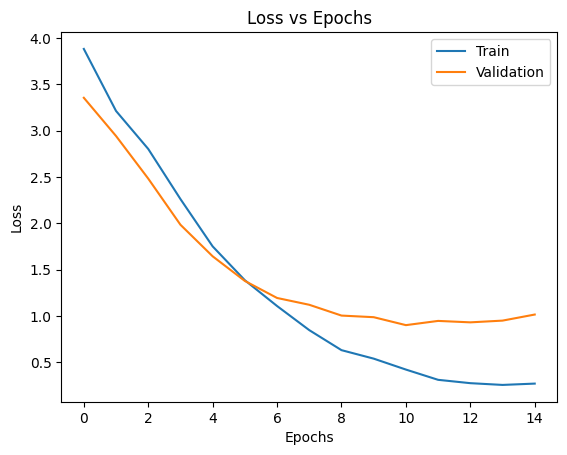

In [44]:
plot_losses(train_losses, val_losses)

In [45]:
from nltk.translate.bleu_score import corpus_bleu

test_loader = DataLoader(test_set, batch_size=128)

generated_captions = []
reference_captions = []

attention_model.eval()
with torch.no_grad():
    for question, answer in tqdm(test_loader):
        question = question.to(device)

        generated_answer = attention_model.module.answer(question, max_length=50)
        answer = sp.decode_ids(answer.cpu().tolist())
        
        generated_captions += generated_answer
        reference_captions += answer

bleu_score = corpus_bleu(reference_captions, generated_captions)
print("BLEU Score:", bleu_score)

100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


BLEU Score: 0.8349259393982036


In [46]:
import random

for _ in range(3):
    question, answer = random.choice(test_set)
    attention_model.eval()
    with torch.no_grad():
        question = torch.tensor(question).to(device).unsqueeze(0)
        question = question.to(device)

        generated_answer = attention_model.module.answer(question, max_length=50)
        generate_answer = ' '.join(generated_answer)
        answer = ''.join(sp.decode_ids(answer.tolist()))
        question = ' '.join(sp.decode_ids(question.cpu().tolist()))
        
        print(f'Question: {question}\nReference Answer: {answer}\nGenerated Answer: {generated_answer}\n')

Question: You are so ugly
Reference Answer: Noted.
Generated Answer: ['Noted.']

Question: I'm going to need a new answer
Reference Answer: I have one answer for each kind of question.
Generated Answer: ['Gotlad you']

Question: I love a spirited debate
Reference Answer: It's nice to have things you love.
Generated Answer: ["It's nice to have things you love."]

